## Import necessary libraries

In [48]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from skimage.transform import resize
from sklearn import preprocessing
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import os.path
import seaborn as sns
import tensorflow as tf
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

## Load dataset

In [ ]:
image_dir = 'E:\Datasets\Food101\images\*'
SIZE = 224

In [4]:
i = 0
from skimage import img_as_ubyte
train_images = []
train_labels = [] 
for directory_path in glob.glob(image_dir):
    if i==30:
        break
    i+=1
    label = directory_path.split("/")[-1]
    x = int(0)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3)

        # Resize the image to 224x224 pixels
        img = tf.image.resize(img, (224, 224))

        # Convert RGB to BGR
        img = tf.reverse(img, axis=[-1])  # Convert from RGB to BGR

        # Normalize pixel values to the range [-1, 1]
        img = tf.image.per_image_standardization(img)
        

        # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
        train_images.append(img)
        train_labels.append(label)
        x = x + int(1)
        if x == int(100):
            break

In [5]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [6]:
print(train_images.shape)
print(train_labels.shape)

(3000, 224, 224, 3)
(3000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


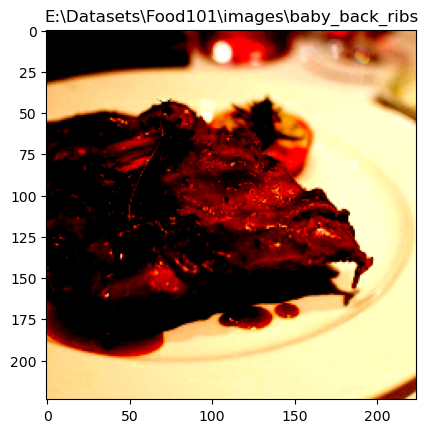

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


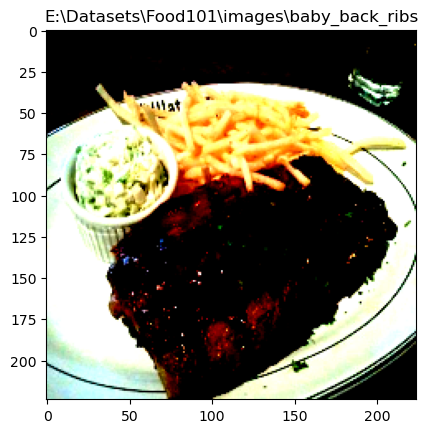

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


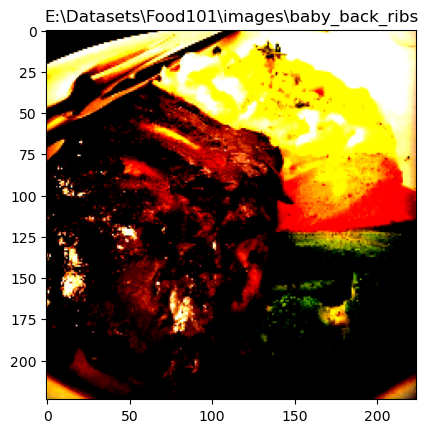

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


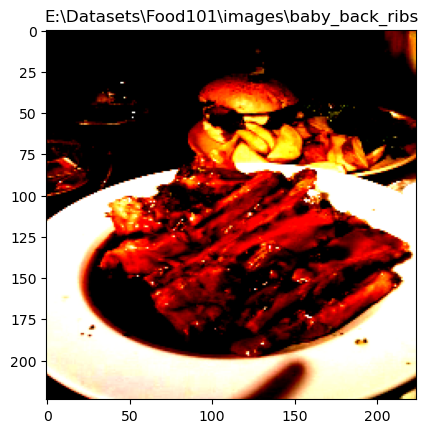

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


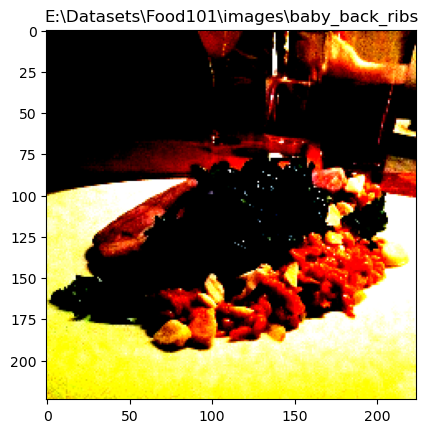

In [10]:
a, b = 100, 105
# Print the first 5 images and their labels from the training set in rgb (they are in BGR at this point)
for i in range(a, b):
    # create tmp image
    tmp = train_images[i]
    # convert from BGR to RGB
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    # plot the image
    plt.figure()
    plt.imshow(tmp)
    plt.title(train_labels[i])
    plt.show()

In [16]:
i = 0
test_images = []
test_labels = [] 
for directory_path in glob.glob(image_dir):
    if i==30:
        break
    i+=1
    label = directory_path.split("/")[-1]
    x = int(0)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        x = x +int(1)
        if x == int(100):
            break
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):    
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3)

        # Resize the image to 224x224 pixels
        img = tf.image.resize(img, (224, 224))

        # Convert RGB to BGR
        img = tf.reverse(img, axis=[-1])  # Convert from RGB to BGR

        # Normalize pixel values to the range [-1, 1]
        img = tf.image.per_image_standardization(img)
        # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
        test_images.append(img)
        test_labels.append(label)
        x = x + int(1)
        if x == int(130):
            break

In [17]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [18]:
print(test_images.shape)
print(test_labels.shape)

(900, 224, 224, 3)
(900,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


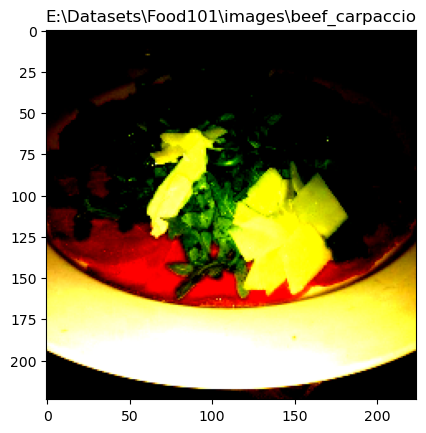

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


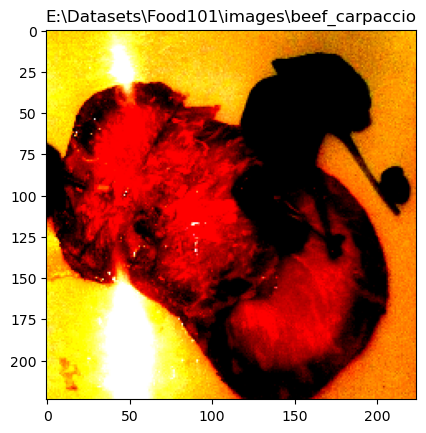

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


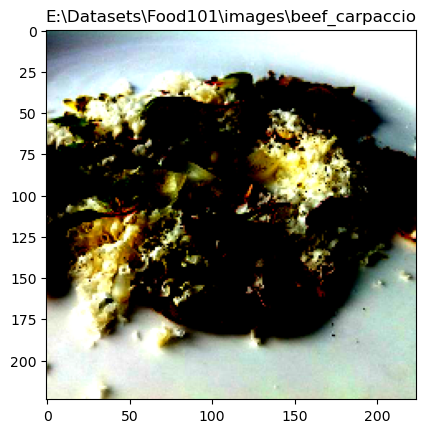

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


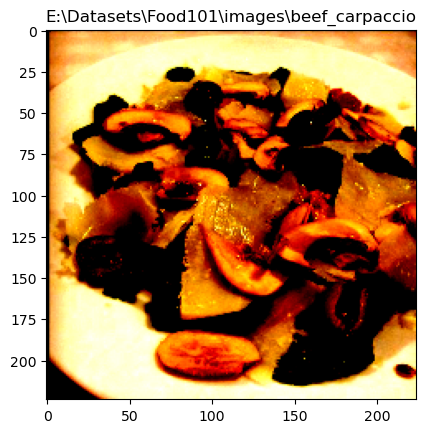

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


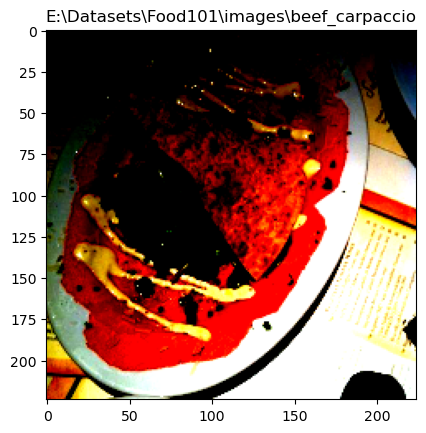

In [21]:
a, b = 100, 105
# Print the first 5 images and their labels from the training set in rgb (they are in BGR at this point)
for i in range(a, b):
    # create tmp image
    tmp = test_images[i]
    # convert from BGR to RGB
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    # plot the image
    plt.figure()
    plt.imshow(tmp)
    plt.title(test_labels[i])
    plt.show()

## Preprocess images

In [25]:
encoder = preprocessing.LabelEncoder()
encoder.fit(test_labels)
test_labels_encoded = encoder.transform(test_labels)
encoder.fit(train_labels)
train_labels_encoded = encoder.transform(train_labels)

In [27]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [28]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

## Build model

#### Create the feature extractor for VGG

In [29]:
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 1)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

#### Load the VGG16 model

In [30]:
# Load the VGG16 base model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model (optional)
for layer in base_model.layers:
    layer.trainable = False

# Create a custom head for your specific task
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(30, activation='softmax')(x)  # Adjust NUM_CLASSES as needed

# Create the final model by combining the base model and custom head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

c:\Users\ASUS\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [31]:
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(101, activation = 'softmax')(x)

In [32]:
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0   

In [34]:
monitor_metric = 'val_accuracy'
checkpoint_callback = ModelCheckpoint('model_best.h5', 
                                       monitor=monitor_metric,
                                       save_best_only=True,
                                       mode='max',  # Use 'min' for loss and 'max' for accuracy
                                       verbose=1)

In [36]:
history = model.fit(x_train, y_train_one_hot, epochs=50, validation_data = (x_test, y_test_one_hot), callbacks=[checkpoint_callback])

Epoch 1/50
94/94 [==============================] - ETA: 0s - loss: 3.0309 - accuracy: 0.1660
Epoch 1: val_accuracy improved from -inf to 0.50667, saving model to model_best.h5
94/94 [==============================] - 423s 5s/step - loss: 3.0309 - accuracy: 0.1660 - val_loss: 2.0101 - val_accuracy: 0.5067
Epoch 2/50
94/94 [==============================] - ETA: 0s - loss: 1.6595 - accuracy: 0.5827
Epoch 2: val_accuracy improved from 0.50667 to 0.87778, saving model to model_best.h5
94/94 [==============================] - 391s 4s/step - loss: 1.6595 - accuracy: 0.5827 - val_loss: 0.8208 - val_accuracy: 0.8778
Epoch 3/50
94/94 [==============================] - ETA: 0s - loss: 0.7725 - accuracy: 0.8537
Epoch 3: val_accuracy improved from 0.87778 to 0.96000, saving model to model_best.h5
94/94 [==============================] - 396s 4s/step - loss: 0.7725 - accuracy: 0.8537 - val_loss: 0.3703 - val_accuracy: 0.9600
Epoch 4/50
94/94 [==============================] - ETA: 0s - loss: 0.310

KeyboardInterrupt: 

In [37]:
history = model.fit(x_train, y_train_one_hot, epochs=1, validation_data = (x_test, y_test_one_hot), callbacks=[checkpoint_callback])

94/94 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 1.00000
94/94 [==============================] - 417s 4s/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 1.0000


## Save and load model 

#### Save

In [39]:
model.save('models/modelV1.h5')

#### Load

In [40]:
model1 = tf.keras.models.load_model('models/modelV1.h5')

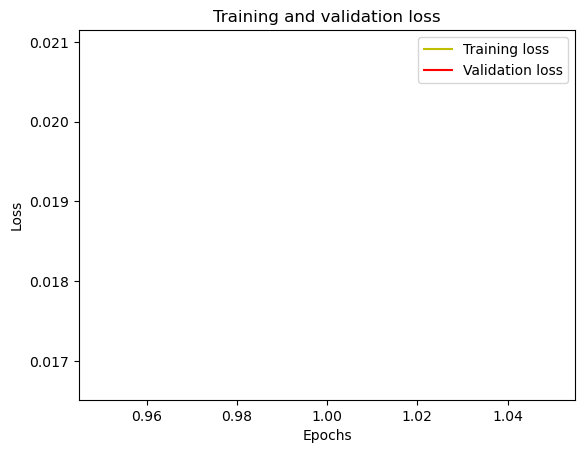

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

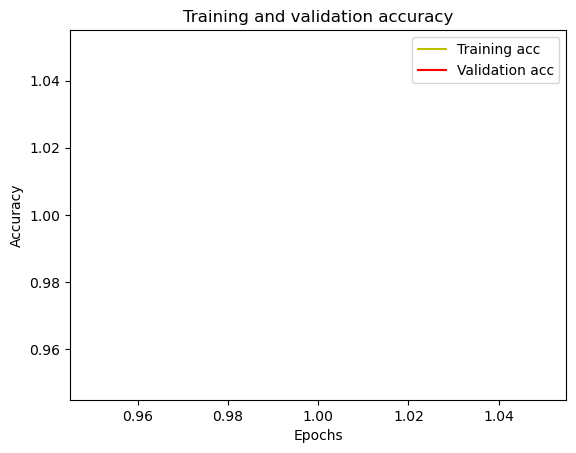

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate

In [45]:
prediction_NN = model1.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = encoder.inverse_transform(prediction_NN)

29/29 [==============================] - 98s 3s/step


[[30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 30  0  0  0  0  0 

<Axes: >

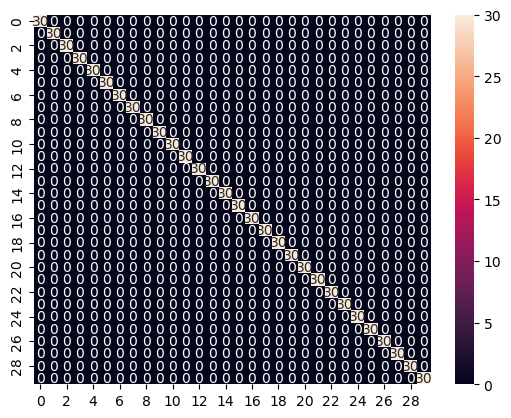

In [49]:
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 153ms/step
The prediction for this image is:  ['E:\\Datasets\\Food101\\images\\caesar_salad']
The actual label for this image is:  E:\Datasets\Food101\images\caesar_salad


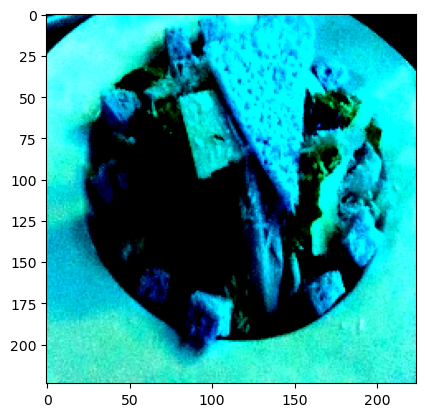

In [51]:
n=345
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) 
prediction = np.argmax(model1.predict(input_img))  
prediction = encoder.inverse_transform([prediction]) 
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

## Predict test images

#### Prediction function

In [53]:
# Predict one image from a path
def predict_one_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (SIZE, SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img)
    img = img.astype('float32')
    img /= 255
    plt.imshow(img)
    input_img = np.expand_dims(img, axis=0) 
    prediction = np.argmax(model1.predict(input_img))  
    prediction = encoder.inverse_transform([prediction]) 
    print("The prediction for this image is: ", prediction)

#### Predict

CEASER (легендарный тот самый)

1/1 [==============================] - 0s 124ms/step
The prediction for this image is:  ['E:\\Datasets\\Food101\\images\\caesar_salad']


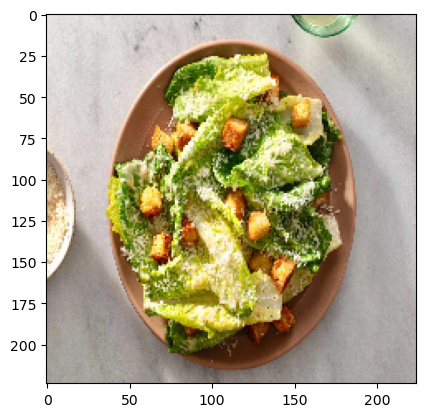

In [54]:
predict_one_image('E:/Datasets/Food101/test/the_ceaser.jpeg')

LEGENDA PAKHLAVA

1/1 [==============================] - 0s 138ms/step
The prediction for this image is:  ['E:\\Datasets\\Food101\\images\\beignets']


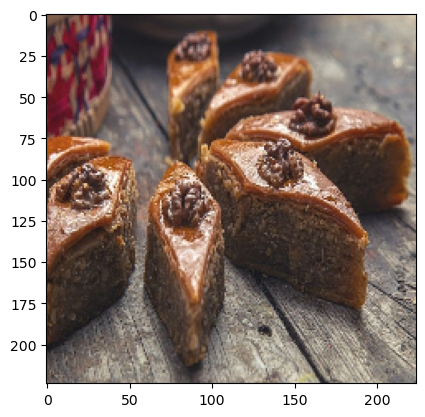

In [57]:
predict_one_image('E:/Datasets/Food101/test/BAKLAVA_LEGENDA.jpeg')

baklava

1/1 [==============================] - 0s 137ms/step
The prediction for this image is:  ['E:\\Datasets\\Food101\\images\\baklava']


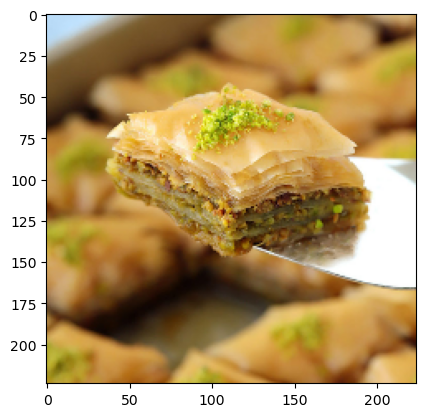

In [58]:
predict_one_image("E:/Datasets/Food101/test/lifted_BAKLAVA.jpg")

In [56]:
# output all possible labels
labels = []
for i in range(0, len(test_labels)):
    labels.append(test_labels[i])
labels = np.array(labels)
labels = np.unique(labels)
print(labels)


['E:\\Datasets\\Food101\\images\\apple_pie'
 'E:\\Datasets\\Food101\\images\\baby_back_ribs'
 'E:\\Datasets\\Food101\\images\\baklava'
 'E:\\Datasets\\Food101\\images\\beef_carpaccio'
 'E:\\Datasets\\Food101\\images\\beef_tartare'
 'E:\\Datasets\\Food101\\images\\beet_salad'
 'E:\\Datasets\\Food101\\images\\beignets'
 'E:\\Datasets\\Food101\\images\\bibimbap'
 'E:\\Datasets\\Food101\\images\\bread_pudding'
 'E:\\Datasets\\Food101\\images\\breakfast_burrito'
 'E:\\Datasets\\Food101\\images\\bruschetta'
 'E:\\Datasets\\Food101\\images\\caesar_salad'
 'E:\\Datasets\\Food101\\images\\cannoli'
 'E:\\Datasets\\Food101\\images\\caprese_salad'
 'E:\\Datasets\\Food101\\images\\carrot_cake'
 'E:\\Datasets\\Food101\\images\\ceviche'
 'E:\\Datasets\\Food101\\images\\cheese_plate'
 'E:\\Datasets\\Food101\\images\\cheesecake'
 'E:\\Datasets\\Food101\\images\\chicken_curry'
 'E:\\Datasets\\Food101\\images\\chicken_quesadilla'
 'E:\\Datasets\\Food101\\images\\chicken_wings'
 'E:\\Datasets\\Food101\\im